Group Final Report

Introduction

Video games have become a significant part of modern entertainment, with millions of players worldwide engaging in various gaming platforms. Understanding player behavior is crucial for game developers and researchers, as it helps optimize resources, improve user experience, and tailor marketing strategies. In this project, we analyze data from a Minecraft research server operated by a UBC Computer Science research group led by Frank Wood. The dataset records player characteristics and session details, providing insights into gaming habits.

Our specific research question is: Can game experience, age, and gender predict whether a player is a high contributor (played more than 3 hours)? High contributors are valuable because they generate more gameplay data, which is essential for research purposes. By identifying factors that correlate with high playtime, the research team can better target recruitment efforts and allocate server resources efficiently.

Dataset Description
The data consists of two structured files:

- players.csv (197 unique players)

experience: Categorical skill level (Pro, Veteran, Regular, Amateur, Beginner)

subscribe: Boolean (whether the player subscribed to a newsletter)

hashedEmail: Unique identifier (anonymized)

played_hours: Total hours played (numeric)

name: Player’s chosen username (String)

gender: Categorical (Male, Female, Non-binary)

age: Numeric (player’s age in years)


- sessions.csv (1,536 gameplay sessions)

hashedEmail: Unique player identifier Unique identifier (anonymized)

start_time / end_time: Timestamps of gameplay sessions

original_start_time / original_end_time: Unix epoch timestamps



Loading necessary libraries and wrangling/cleaning the data to the format for the planned analysis:

In [4]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(themis)
library(cowplot)
options(repr.matrix.max.rows = 5)

players_url <- "https://raw.githubusercontent.com/elilyliu/Group-4-project/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/elilyliu/Group-4-project/refs/heads/main/sessions.csv"

players <- read_csv(players_url) |> rename(age = Age)
sessions <- read_csv(sessions_url)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


For the purpose of this analysis, players are categorized into three contribution levels based on total playtime: High contributors (≥3 hours), who provide substantial gameplay data; Medium contributors (1-3 hours), representing moderate engagement; and Low contributors (<1 hour), indicating minimal playtime. This classification helps identify which player characteristics are most associated with high engagement levels. 

In [5]:
players <- players |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")),
           gender = as_factor(gender),
           contributor_type = case_when(
              played_hours >= 3 ~ "High",
              played_hours < 3 & played_hours >= 1 ~ "Medium",
              played_hours < 1 ~ "Low")) |>
    mutate(contributor_type = factor(contributor_type)) |>
    drop_na()
cat("Figure 1: Player Dataset\n")
players

Figure 1: Player Dataset


experience,subscribe,hashedEmail,played_hours,name,gender,age,contributor_type
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,High
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,High
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,Low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,Low
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,Medium


Summarizing the players dataset, the majority of players seem to have an Amateur experience level, however, the experience level that played for the most amount of total hours are regular players (Fig 2). Classifying high contributors to be those who played for 3 or more hours, only 19 players in the dataset are considered to be high contributors with an average age of 19.8 years (Fig. 3). The Majority of players are low contributors (152). Because of these imbalances in data, when performing our classification prediction, it is necessary to scale the data.

In [3]:
avg_experience <- players |>
    group_by(experience) |>
    summarize(average_played_hours = mean(played_hours, na.rm = TRUE),
             average_age = mean(age),
             count = n())

contributors <- players |>
    group_by(contributor_type) |>
    summarise(count = n(), 
             average_age = mean(age))

cat("Figure 2:Summarized Player Dataset Information\n")
avg_experience
cat("Figure 3:Summarized Contibutor type Information\n")
contributors

Figure 2:Summarized Player Dataset Information


experience,average_played_hours,average_age,count
<fct>,<dbl>,<dbl>,<int>
Beginner,1.2485714,21.65714,35
Amateur,6.0174603,20.25397,63
Regular,18.7257143,20.60000,35
Pro,2.7846154,16.92308,13
Veteran,0.6479167,20.95833,48


Figure 3:Summarized Contibutor type Information


contributor_type,count,average_age
<fct>,<int>,<dbl>
High,19,19.84211
Low,152,20.57895
Medium,23,20.69565


Visualizing this data, we see that there appears to be a connection between total hours played and a players' experience level, age, and gender identity (Fig. 4). It appears that 'regular' players around the age range of 15-25 and who identify as male contributed the most amount of hours played collectively. However, to identify whether they are the types of players to contribute the most data, we need to perform k-nearest neighbour classification.

Figure 4: Visualizations of potential factors in the Players Dataset


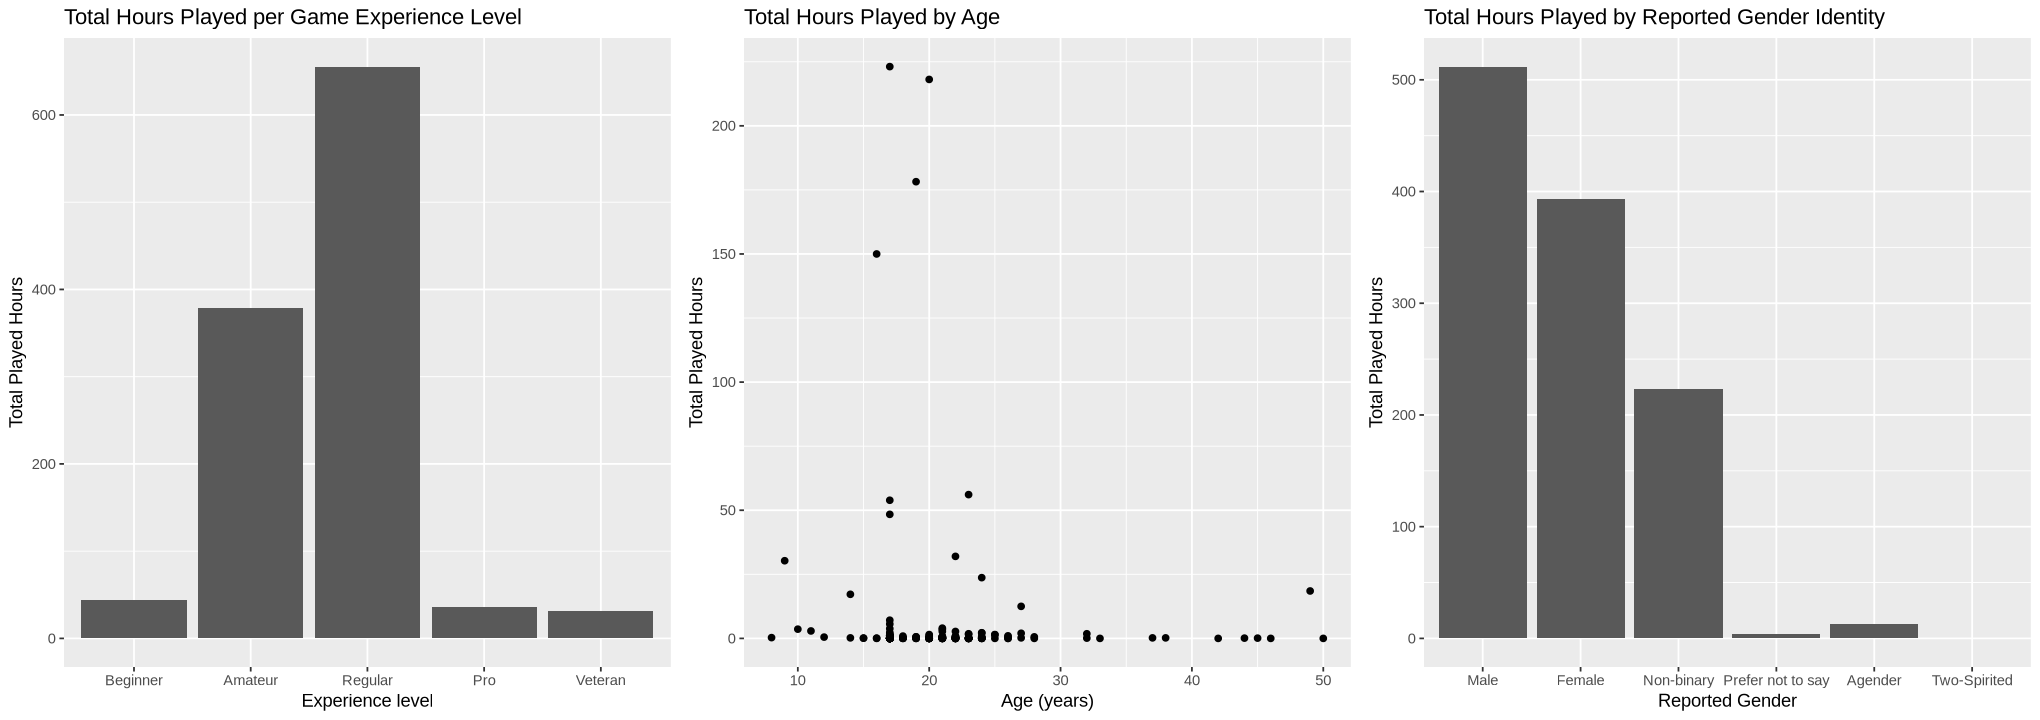

In [21]:
player_plot_experience <- ggplot(players, aes(x=experience, y=played_hours)) +
    geom_bar(stat="identity") +
    labs(x="Experience level", y="Total Played Hours", title="Total Hours Played per Game Experience Level")

player_plot_age <- ggplot(players, aes(x=age, y=played_hours)) +
    geom_point() +
    labs(x="Age (years)", y="Total Played Hours", title="Total Hours Played by Age")

player_plot_gender <- ggplot(players, aes(x=gender, y=played_hours)) +
    geom_bar(stat="identity") +
    labs(x="Reported Gender", y="Total Played Hours", title="Total Hours Played by Reported Gender Identity")

options(repr.plot.width=17, repr.plot.height=6)
cat("Figure 4: Visualizations of potential factors in the Players Dataset\n")
plot_grid(player_plot_experience, player_plot_age, player_plot_gender, ncol = 3)

To perform k-nn classification, we first split the data into a training set (70% of the data) and a testing set (30% of the data). In doing so, we'll have data available to both train the model and evaluate its accuracy. The training data will be used while building the classifier, which will then be used to predict the labels in the test set (Timbers et al., 2024, Chapter 6.3).
Due to the imbalance in the factors of our data, we scale our predictors to have a standard deviation of 1 and a mean of 0. As shown previously, there is also a significant imbalance in the distribution of the classification types, where Low contributors severely outnumber High and Medium contributors. To account for this, we upscale to ensure the different types are on equal levels. 
<br>
We then use 5-fold cross validation to further split our training set into 5 smaller groups to evaluate the accuracy of our classifier, testing different values of k from 1 to 10 and finally choosing the value for k with the highest accuracy.

Figure 5: Visualization of the accuracy for different values of k


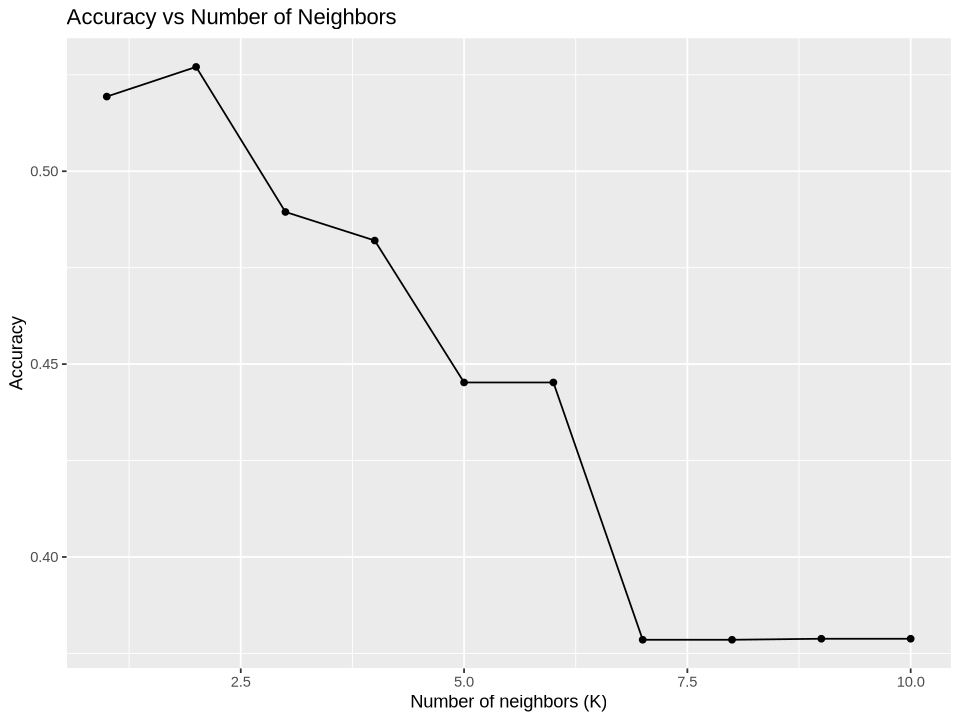

In [6]:
set.seed(2222) 
selected_players <- players  |>
    mutate(experience_label = as.numeric(experience),
          gender_label = as.numeric(gender)) |>
    select(contributor_type, gender, gender_label, experience, experience_label, age)

player_split <- initial_split(selected_players, prop = 0.7, strata = contributor_type)  
player_train <- training(player_split)   
player_test <- testing(player_split)

player_recipe <- recipe(contributor_type ~ experience_label + age + gender_label, data = player_train) |>
    step_normalize(all_predictors()) |>
    step_upsample(contributor_type, over_ratio = 1, skip = TRUE)

knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = contributor_type)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
cross_val_plot <- ggplot(knn_results, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Number of neighbors (K)", y="Accuracy", title = "Accuracy vs Number of Neighbors")

options(repr.plot.width=8, repr.plot.height=6)
cat("Figure 5: Visualization of the accuracy for different values of k\n")
cross_val_plot

Analyzing the plot created from the results of the cross validation, it was found that k=2 resulted in the highest accuracy compared to other values (Fig. 5), therefore 2 is the optimal k value to use for our model.
<br>
With this newfound value, we'll create our K nearest neighbors classifier that predicts classifications based on the 2 nearest neighbors.

In [18]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_train)

player_predictions <- predict(player_fit, player_test) |>
    bind_cols(player_test)

mnist_metrics <- player_predictions |>
    metrics(truth = contributor_type, estimate = .pred_class)

player_mat <- player_predictions |> 
      conf_mat(truth = contributor_type, estimate = .pred_class)
cat("Figure 6: Accuracy metric for result of classification model\n")
mnist_metrics
cat("Figure 7: Confusion matrix for result of classification model\n")
player_mat

Figure 6: Accuracy metric for result of classification model


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.54237288
kap,multiclass,0.01239926


Figure 7: Confusion matrix for result of classification model


          Truth
Prediction High Low Medium
    High      2  12      2
    Low       6  29      3
    Medium    0   4      1

After creating our model and testing with our testing data, the classifier resulted in about 54% accuracy where the model is more likely to predict low, often misclassifying both high and medium (Fig. 6 and Fig. 7). However, after visualizing the data, the model suggests that the players how are more likely to contribute high amounts of data (played for more hours) are newer players like Amateur and Regular in the age range of young teen to young adult (12-23) (Fig.8). The model also suggests that those who identify as male are also more likely to be high contributors of data. These results closely match the trends from the data before the classification model (Fig.4).

Figure 8: Visualization of summary of classification results


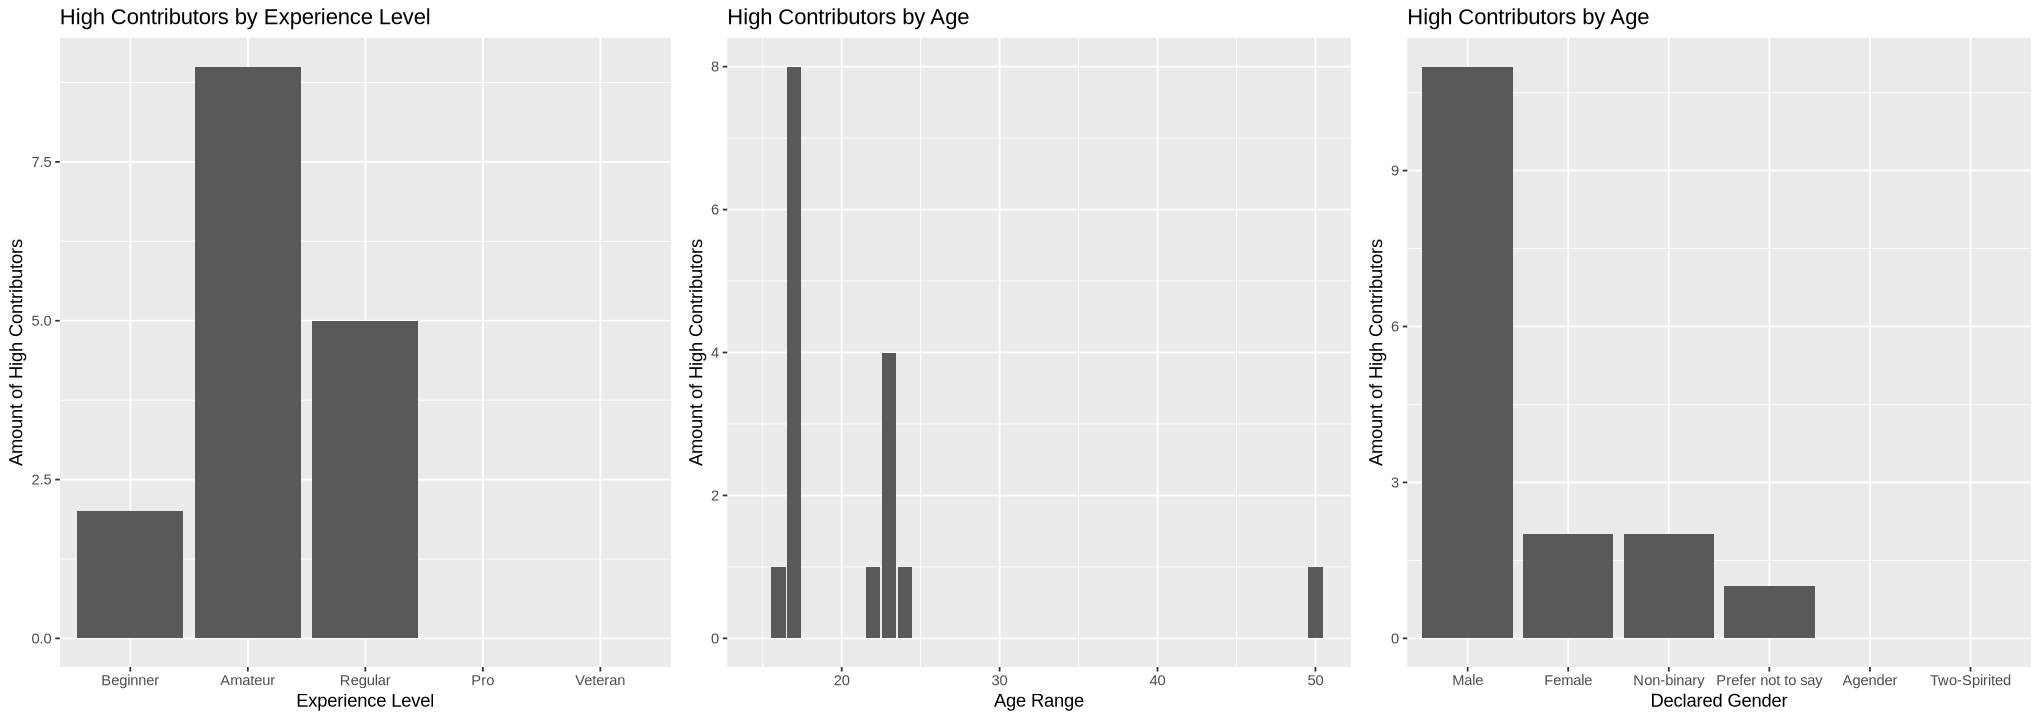

In [17]:
contributor_summary <- player_predictions |>
  group_by(experience_label, age, gender_label, experience, gender, .pred_class) |>
  summarise(count = n(), .groups = "drop") |>
  pivot_wider(names_from = .pred_class, values_from = count, values_fill = 0)

experience_summary <- ggplot(contributor_summary, aes(x = experience, y = High)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Experience Level", 
         x = "Experience Level", 
         y = "Amount of High Contributors")

age_summary <- ggplot(contributor_summary, aes(x = age, y = High)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Age", 
         x = "Age Range", 
         y = "Amount of High Contributors") 

gender_summary <- ggplot(contributor_summary, aes(x = gender, y = High)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Age", 
         x = "Declared Gender", 
         y = "Amount of High Contributors") 

options(repr.plot.width=17, repr.plot.height=6)
cat("Figure 8: Visualization of summary of classification results\n")
plot_grid(experience_summary,age_summary, gender_summary, ncol = 3)